In [1]:
import pandas as pd

In [2]:
# Load df from CSV
df = pd.read_csv("../data/df_bbch.csv", parse_dates=['date'])

print(df.shape)
df.head()

(4542, 29)


,date,station,depth,op,mean_sst,mean_airt,SSM,SST,year,doy,...,VH,VV,angle,lc,BASE_TEMP,cum_GDD_air,cum_GDD_soil,cum_GDD,BBCH,cum_SSM
0,2015-04-25,MB1,0 to 5 cm,0,10.166667,7.8365,0.131444,14.981481,2015,115,...,-20.0,-13.0,40.0,146.0,5,2.8365,5.166667,4.001583,0.0,0.131444
1,2015-04-25,MB11,0 to 5 cm,0,8.616667,8.3805,0.273259,12.581481,2015,115,...,-22.0,-14.0,42.0,158.0,10,2.8365,5.166667,4.001583,0.0,0.404704
2,2015-04-25,MB12,0 to 5 cm,0,5.350000,8.0125,0.311259,14.271247,2015,115,...,-22.0,-12.0,42.0,146.0,5,5.8490,5.516667,5.682833,0.0,0.715963
3,2015-04-25,MB2,0 to 5 cm,0,13.270938,8.3070,0.340557,15.961012,2015,115,...,-18.0,-9.0,40.0,146.0,5,9.1560,13.787605,11.471802,0.0,1.056520
4,2015-04-25,MB3,0 to 5 cm,0,8.716667,9.0030,0.271333,12.774074,2015,115,...,-22.0,-13.0,40.0,158.0,10,9.1560,13.787605,11.471802,0.0,1.327854


In [3]:
from inversion import Inverse

In [4]:
crop_data_final_sorted = {
    133: { # Barley
        'bbch_k_b': [ # Derived from Wheat in Wang et al. 2024 Fig 4 as proxy
            (0, 80, 1), (10, 70, 5), (20, 30, 30), (50, 10, 50), (75, 15, 60), (100, 1, 70)
        ]
    },
    136: { # Oats
        'bbch_k_b': [ # Derived from Wheat in Wang et al. 2024 Fig 4 as proxy
            (0, 80, 1), (10, 70, 5), (20, 30, 30), (50, 10, 50), (75, 15, 60), (100, 1, 70)
        ]
    },
    146: { # Spring Wheat
        'bbch_k_b': [ # Derived from Wang et al. 2024 Fig 4
            (0, 80, 1), (10, 70, 5), (20, 30, 30), (50, 10, 50), (75, 15, 60), (100, 1, 70)
        ]
    },
    147: { # Corn/Maize
        'bbch_k_b': [ # Derived from Wang et al. 2024 Fig 4
            (0, 100, 1), (10, 80, 5), (20, 50, 30), (40, 30, 50), (60, 20, 60), (80, 10, 70), (100, 1, 80)
        ]
    },
    153: { # Canola
        'bbch_k_b': [ # Default - Not in Wang et al. 2024
            (0, 40, 1), (10, 20, 5), (20, 40, 25), (40, 20, 70), (60, 22, 95), (80, 20, 100), (100, 15, 110)
        ]
    },
    157: { # Sunflower
        'bbch_k_b': [ # Default - Not in Wang et al. 2024
            (0, 100, 1), (10, 80, 5), (20, 50, 30), (40, 30, 50), (60, 20, 60), (80, 10, 70), (100, 1, 80)
        ]
    },
    158: { # Soybean
        'bbch_k_b': [ # Default - Not in Wang et al. 2024
            (0, 40, 1), (10, 20, 5), (20, 40, 25), (40, 20, 70), (60, 22, 95), (80, 20, 100), (100, 15, 110)
        ]
    },
    167: { # Dry Beans (Phaseolus)
        'bbch_k_b': [ # Default - Not in Wang et al. 2024
            (0, 40, 1), (10, 20, 5), (20, 40, 25), (40, 20, 70), (60, 22, 95), (80, 20, 100), (100, 15, 110)
        ]
    }
}

In [5]:
crop_bounds = {
    133: {  # Barley
        'cbound': (0, 0.1, 0.5),
        'sbound': (0, 0.025, 0.5), # surface roughness or rms height [m]
        'lbound': (0, 0.075, 0.5), # correlation length [m]
        'wbound': (0, 0.1, 0.5)
    },
    136: {  # Oats
        'cbound': (0, 0.1, 0.5),
        'sbound': (0, 0.025, 0.5),
        'lbound': (0, 0.075, 0.5), # correlation length [m]
        'wbound': (0, 0.1, 0.5)
    },
    146: {  # Spring Wheat
        'cbound': (0, 0.1, 0.5),
        'sbound': (0, 0.025, 0.5),
        'lbound': (0, 0.075, 0.5), # correlation length [m]
        'wbound': (0, 0.1, 0.5)
    },
    147: {  # Corn
        'cbound': (0, 0.1, 0.5),
        'sbound': (0, 0.025, 0.5),
        'lbound': (0, 0.075, 0.5), # correlation length [m]
        'wbound': (0, 0.1, 0.5)
    },
    153: {  # Canola and Rapeseed
        'cbound': (0, 0.1, 0.5),
        'sbound': (0, 0.025, 0.5),
        'lbound': (0, 0.075, 0.5), # correlation length [m]
        'wbound': (0, 0.1, 0.5)
    },
    157: {  # Sunflower
        'cbound': (0, 0.1, 0.5),
        'sbound': (0, 0.025, 0.5),
        'lbound': (0, 0.075, 0.5), # correlation length [m]
        'wbound': (0, 0.1, 0.5)
    },
    158: {  # Soybeans
        'cbound': (0, 0.1, 0.5),
        'sbound': (0, 0.025, 0.5),
        'lbound': (0, 0.075, 0.5), # correlation length [m]
        'wbound': (0, 0.1, 0.5)
    },
    167: {  # Beans
        'cbound': (0, 0.1, 0.5),
        'sbound': (0, 0.025, 0.5),
        'lbound': (0, 0.075, 0.5), # correlation length [m]
        'wbound': (0, 0.1, 0.5)
    }
}

In [6]:

# Set the bacscattering models
RT_models = {
    'RT_s': 'PRISM1', # options: 'AIEM', 'PRISM1'
    'RT_c': 'Diff' # options: 'Diffuse', 'Specular'
}

inv = Inverse(fGHz=5.405, models=RT_models, acftype='exp', crop_bbch_k_b_coff=crop_data_final_sorted)

In [7]:
inv_df = inv.run(df, crop_bounds)

/home/morteza/usask/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/morteza/usask/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/morteza/usask/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/morteza/usask/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/morteza/usask/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n1 * np.cos(theta_rad

In [8]:
print(inv_df.shape)
inv_df.head()

(4424, 37)


,date,station,depth,op,mean_sst,mean_airt,SSM,SST,year,doy,...,BBCH,cum_SSM,d,c,w,vvv,vvs,s,l,rvi
0,2015-04-25,MB1,0 to 5 cm,0,10.166667,7.8365,0.131444,14.981481,2015,115,...,0.0,0.131444,0.542216,0.223872,0.038168,-15.143286,-17.094702,0.002778,0.075,0.665350
1,2015-04-25,MB11,0 to 5 cm,0,8.616667,8.3805,0.273259,12.581481,2015,115,...,0.0,0.404704,0.229865,0.388830,0.000165,-17.824103,-16.325193,0.002802,0.075,0.547228
2,2015-04-25,MB12,0 to 5 cm,0,5.350000,8.0125,0.311259,14.271247,2015,115,...,0.0,0.715963,0.300340,0.295478,0.000311,-15.626653,-14.470647,0.003304,0.075,0.363636
3,2015-04-25,MB2,0 to 5 cm,0,13.270938,8.3070,0.340557,15.961012,2015,115,...,0.0,1.056520,0.367737,0.231935,0.037651,-11.998367,-12.022266,0.004321,0.075,0.447263
4,2015-04-25,MB3,0 to 5 cm,0,8.716667,9.0030,0.271333,12.774074,2015,115,...,0.0,1.327854,0.188837,0.152568,0.073076,-15.188573,-17.024662,0.002222,0.075,0.447263


In [9]:
# inv_df.to_csv("../data/inv_df.csv", index=False)

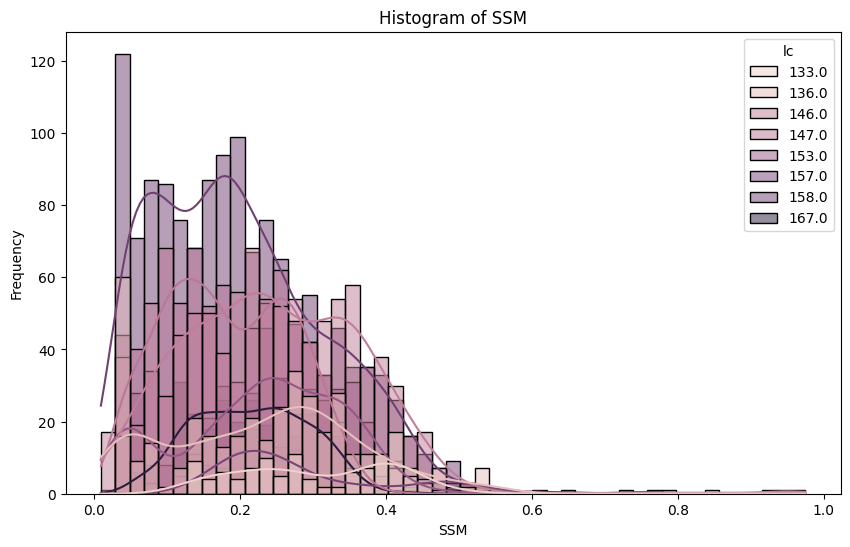

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'gp_merged' DataFrame is already created as in the provided code.

plt.figure(figsize=(10, 6))
sns.histplot(inv_df, x='SSM', kde=True, hue='lc')
plt.title('Histogram of SSM')
plt.xlabel('SSM')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_5342/369816459.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))


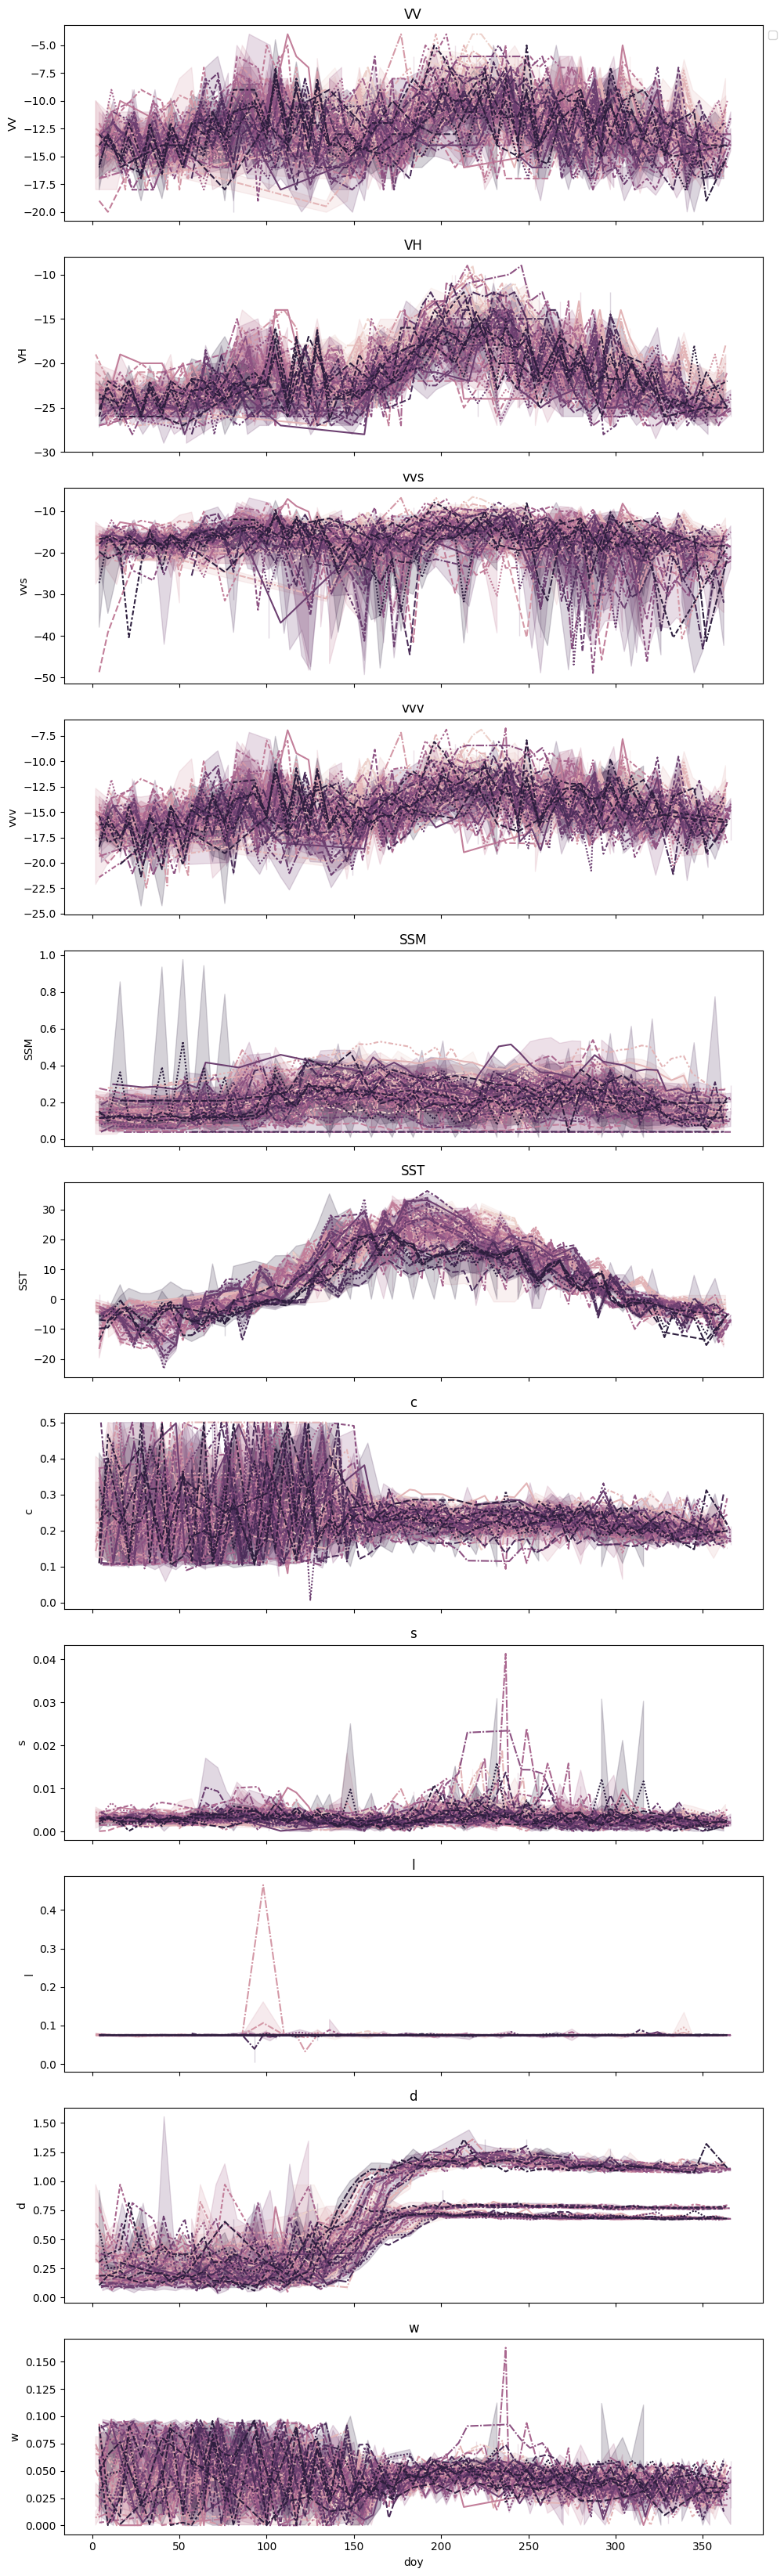

In [11]:
# Assuming 'gp_merged' DataFrame is already created as in the provided code.

parameters = ['VV', 'VH', 'vvs', 'vvv', 'SSM', 'SST', 'c', 's', 'l', 'd', 'w']
num_parameters = len(parameters)

fig, axes = plt.subplots(num_parameters, 1, figsize=(10, 3 * num_parameters), sharex=True)

for i, param in enumerate(parameters):
    sns.lineplot(ax=axes[i], x='doy', y=param, data=inv_df, hue='year', style='lc', legend=False)
    axes[i].set_title(param)
    # Add legend only to the first subplot
    if i == 0:
        axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()